<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/ETA-Prediction/TransitLK_ETA_COO_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup & Data Loading**

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import warnings

warnings.filterwarnings('ignore')

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    dLat, dLon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dLat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2)**2
    return 2 * R * asin(sqrt(a))

print("Upload your TransitLK trip logs:")
uploaded = files.upload()

Upload your TransitLK trip logs:


Saving TransitLK_1770114296072.csv to TransitLK_1770114296072.csv
Saving TransitLK_1768712545951.csv to TransitLK_1768712545951.csv
Saving TransitLK_1768705904623.csv to TransitLK_1768705904623.csv
Saving TransitLK_1769482275640.csv to TransitLK_1769482275640.csv
Saving TransitLK_1770085942785.csv to TransitLK_1770085942785.csv
Saving TransitLK_1769141577728.csv to TransitLK_1769141577728.csv
Saving TransitLK_1769565884989.csv to TransitLK_1769565884989.csv
Saving TransitLK_1769653755416.csv to TransitLK_1769653755416.csv


##**Preprocessing & Feature Engineering**

In [2]:
STOPS_R2B = [
    ("Golumadama Junction", 6.810710, 79.882347), ("Belekkade Jucntion", 6.814647, 79.878669),
    ("Vijitha Halt", 6.817364, 79.875154), ("Maliban Junction", 6.819457, 79.873560),
    ("Lalanka Ratmalana", 6.823173, 79.870894), ("Mount Lavinia Police", 6.825433, 79.869744),
    ("Hena Road", 6.827617, 79.868829), ("Templers' Road", 6.829886, 79.867929),
    ("Mount Lavinia", 6.833045, 79.867268), ("Mount Lavinia Court", 6.837786, 79.867445),
    ("Hotel Road", 6.841953, 79.866814), ("Cemetry/Odeon", 6.844687, 79.866240),
    ("Dehiwala Arpico", 6.848879, 79.865909), ("Dehiwala Junction", 6.851828, 79.865823),
    ("Holy Family Convent", 6.857468, 79.864826), ("Dehiwala Municipal Council", 6.860582, 79.864122),
    ("Roxy Gardens", 6.865106, 79.863141), ("Wellwatte Arpico", 6.868285, 79.862428),
    ("Wellawatte Junction", 6.874023, 79.861318), ("Wellawatte Mosque", 6.876563, 79.860568),
    ("St. Peter's College Bambalapitiya", 6.881175, 79.859226), ("Bambalapitiya Flats", 6.883890, 79.858444),
    ("Vishaka Halt", 6.889274, 79.856858), ("Bambalapitiya Junction", 6.893351, 79.855543)
]

STOPS_B2R = [
    ("Bambalapitiya Junction", 6.894218, 79.857434), ("Vishaka Halt", 6.891731, 79.858405),
    ("ICBT Halt", 6.889393, 79.859099), ("Hindu College Halt", 6.884334, 79.860700),
    ("S. Peter's College Bambalapitiya", 6.881086, 79.861731), ("Savoy Cinema", 6.878835, 79.860094),
    ("Wellawatte Mosque", 6.877105, 79.860591), ("Wellawatte Junction", 6.872737, 79.861786),
    ("Mangala Halt", 6.869242, 79.862412), ("Bodhirukkarama Road", 6.867136, 79.862877),
    ("Sampath Bank", 6.863900, 79.863557), ("Dehiwala Municipal Council", 6.860955, 79.864197),
    ("Waidya Road", 6.857253, 79.865038), ("Dehiwala Junction", 6.850799, 79.866047),
    ("Dehiwala Arpico", 6.846449, 79.866202), ("Cemetry/Odeon Halt", 6.844567, 79.866389),
    ("Hotel Road", 6.840839, 79.867319), ("Mount Lavina Court", 6.838936, 79.867602),
    ("Mount Lavinia", 6.835397, 79.867476), ("Templers' Road", 6.829929, 79.868109),
    ("Hena Road", 6.828185, 79.868771), ("Mount Lavinia Police", 6.825727, 79.869784),
    ("Maliban Junction", 6.821274, 79.872441), ("Vijitha Halt", 6.817455, 79.875316),
    ("Belekkade Junction", 6.815648, 79.877720), ("Ratmalana Airport", 6.812204, 79.881416),
    ("Golumadama Jucntion", 6.809427, 79.883373)
]

def generate_training_data(uploaded_files):
    data = []
    for fn in uploaded_files.keys():
        df = pd.read_csv(fn)
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Determine Direction
        s_lat, s_lng = df.iloc[0]['lat'], df.iloc[0]['lng']
        route_id = 0 if haversine(s_lat, s_lng, 6.8107, 79.8823) < haversine(s_lat, s_lng, 6.8942, 79.8574) else 1
        stops = STOPS_R2B if route_id == 0 else STOPS_B2R

        # Extract Halt Timestamps
        arrivals = []
        for i, (_, s_lat, s_lng) in enumerate(stops):
            df['d'] = df.apply(lambda r: haversine(r['lat'], r['lng'], s_lat, s_lng), axis=1)
            within_50m = df[df['d'] <= 50]
            if not within_50m.empty:
                arrivals.append((i, within_50m.loc[within_50m['d'].idxmin(), 'timestamp']))

        # Build Segments
        for i in range(len(arrivals)):
            for j in range(i + 1, len(arrivals)):
                s_idx, s_time = arrivals[i]
                e_idx, e_time = arrivals[j]
                data.append({
                    'route_id': route_id, 'start_stop': s_idx, 'end_stop': e_idx,
                    'hour': s_time.hour, 'day': s_time.dayofweek,
                    'duration_min': (e_time - s_time).total_seconds() / 60.0
                })
    return pd.DataFrame(data)

master_df = generate_training_data(uploaded)

## **Exploratory Data Analysis (EDA)**

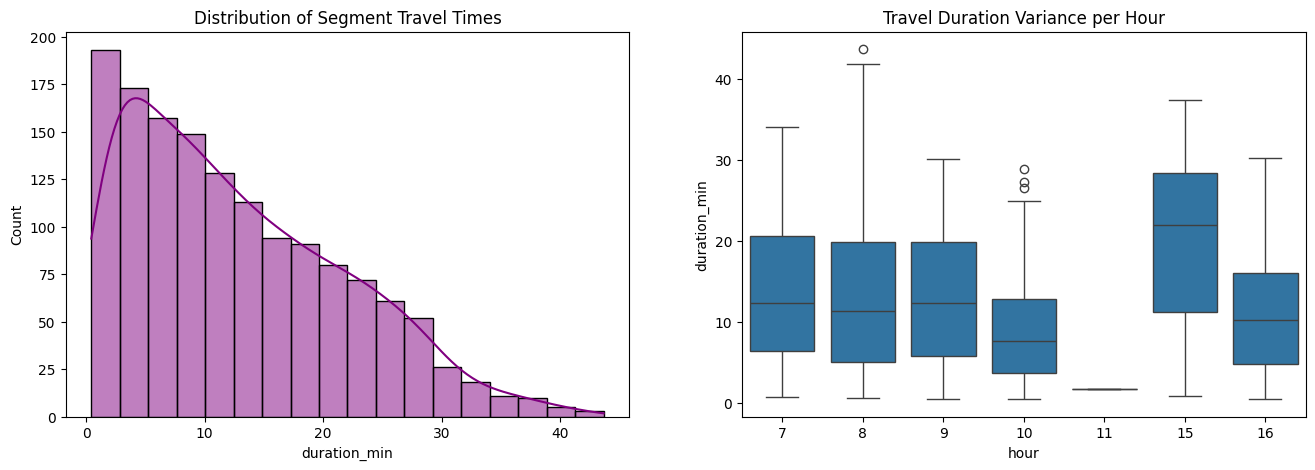

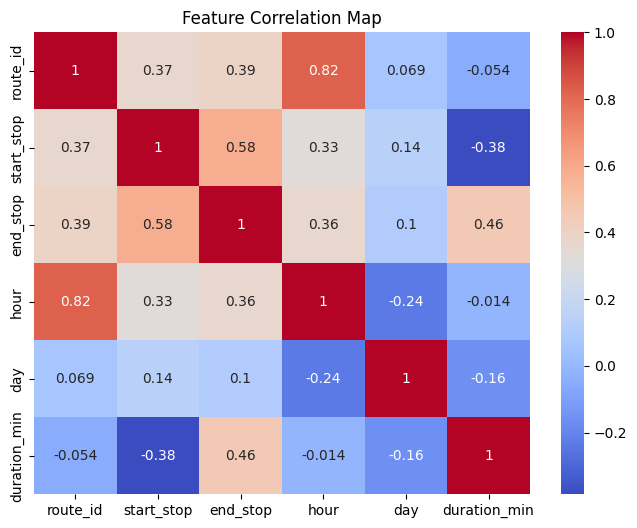

In [3]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.histplot(master_df['duration_min'], kde=True, color='purple')
plt.title("Distribution of Segment Travel Times")

plt.subplot(1, 2, 2)
sns.boxplot(x='hour', y='duration_min', data=master_df)
plt.title("Travel Duration Variance per Hour")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(master_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Map")
plt.show()

## **Model Building & Training**

In [4]:
X = master_df.drop('duration_min', axis=1)
y = master_df['duration_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=1000, max_depth=6, learning_rate=0.05, objective='reg:squarederror'
)

print("Training TransitLK ETA Engine...")
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

Training TransitLK ETA Engine...
[0]	validation_0-rmse:8.54064
[100]	validation_0-rmse:1.60764
[200]	validation_0-rmse:1.55531
[300]	validation_0-rmse:1.55534
[400]	validation_0-rmse:1.57788
[500]	validation_0-rmse:1.62584
[600]	validation_0-rmse:1.70081
[700]	validation_0-rmse:1.73029
[800]	validation_0-rmse:1.78228
[900]	validation_0-rmse:1.81399
[999]	validation_0-rmse:1.85347


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## **Evaluation & Confusion Matrix**

MAE: 0.85 min
RMSE: 1.85 min
R2 Score: 0.96


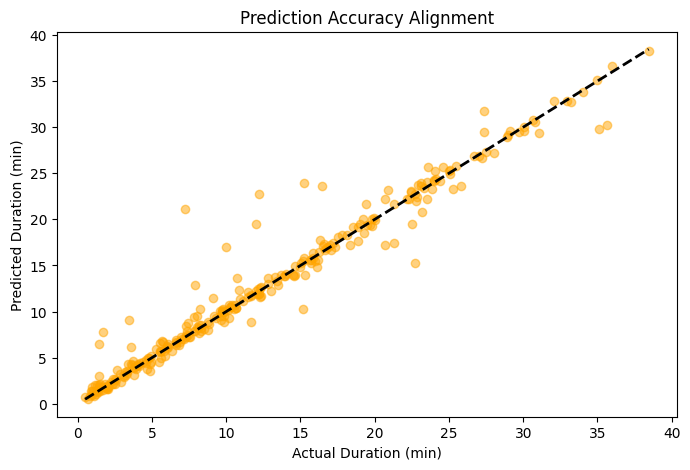

In [5]:
y_pred = model.predict(X_test)

# Regression Evaluation
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} min")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} min")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# Error Visualization (Our Regression Confusion Matrix equivalent)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Duration (min)")
plt.ylabel("Predicted Duration (min)")
plt.title("Prediction Accuracy Alignment")
plt.show()

In [10]:
# @title **TransitLK Live ETA Dashboard**
Route_Direction = "R2B" # @param ["R2B", "B2R"]
Departure_Halt = "Golumadama Junction" # @param ["Golumadama Junction", "Belekkade Jucntion", "Vijitha Halt", "Maliban Junction", "Lalanka Ratmalana", "Mount Lavinia Police", "Hena Road", "Templers' Road", "Mount Lavinia", "Mount Lavinia Court", "Hotel Road", "Cemetry/Odeon", "Dehiwala Arpico", "Dehiwala Junction", "Holy Family Convent", "Dehiwala Municipal Council", "Roxy Gardens", "Wellwatte Arpico", "Wellawatte Junction", "Wellawatte Mosque", "St. Peter's College Bambalapitiya", "Bambalapitiya Flats", "Vishaka Halt", "Bambalapitiya Junction", "ICBT Halt", "Hindu College Halt", "Savoy Cinema", "Mangala Halt", "Bodhirukkarama Road", "Sampath Bank", "Waidya Road", "Cemetry/Odeon Halt", "Ratmalana Airport", "Golumadama Jucntion"]
Arrival_Halt = "Mount Lavinia Court" # @param ["Golumadama Junction", "Belekkade Jucntion", "Vijitha Halt", "Maliban Junction", "Lalanka Ratmalana", "Mount Lavinia Police", "Hena Road", "Templers' Road", "Mount Lavinia", "Mount Lavinia Court", "Hotel Road", "Cemetry/Odeon", "Dehiwala Arpico", "Dehiwala Junction", "Holy Family Convent", "Dehiwala Municipal Council", "Roxy Gardens", "Wellwatte Arpico", "Wellawatte Junction", "Wellawatte Mosque", "St. Peter's College Bambalapitiya", "Bambalapitiya Flats", "Vishaka Halt", "Bambalapitiya Junction", "ICBT Halt", "Hindu College Halt", "Savoy Cinema", "Mangala Halt", "Bodhirukkarama Road", "Sampath Bank", "Waidya Road", "Cemetry/Odeon Halt", "Ratmalana Airport", "Golumadama Jucntion"]
Time = "07:45" # @param {type:"string"}

def predict_trip():
    stops = STOPS_R2B if Route_Direction == "R2B" else STOPS_B2R
    names = [s[0] for s in stops]

    if Departure_Halt not in names or Arrival_Halt not in names:
        return print(f"Error: Selected halt is not valid for the {Route_Direction} route.")

    s_idx, e_idx = names.index(Departure_Halt), names.index(Arrival_Halt)
    if s_idx >= e_idx: return print("Error: Arrival must be after Departure.")

    feats = pd.DataFrame([[0 if Route_Direction=="R2B" else 1, s_idx, e_idx, int(Time.split(":")[0]), datetime.now().weekday()]],
                         columns=X.columns)

    eta = model.predict(feats)[0]
    print(f"\n[TransitLK RESULT]\nEstimated Time: {eta:.2f} minutes")

predict_trip()


[TransitLK RESULT]
Estimated Time: 10.81 minutes


## **Production Export**

In [7]:
joblib.dump(model, 'TransitLK_ETA_Final.pkl')
with open('model_metadata.json', 'w') as f:
    json.dump({"features": list(X.columns), "stops_r2b": [s[0] for s in STOPS_R2B], "stops_b2r": [s[0] for s in STOPS_B2R]}, f)

print("Model saved. Ready for Vaylen production.")

Model saved. Ready for Vaylen production.
